# Import all libraries


In [1]:
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='once')

## Reading and preprocessing dataframe

In [2]:
def preprocessWeather(path_url):
    df = pd.read_csv(path_url)
    df.columns = df.columns.str.replace(' ', '')
    df[['FH', 'T', 'RH']] = df[['FH', 'T', 'RH']] / 10
    df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    df['date'] = df['YYYYMMDD'] +  pd.to_timedelta(df['HH'], unit='h')
    df.drop(columns = ['#STN', 'DD', 'FF', 'FX', 'T10N', 'TD', 'Q', 
                       'P', 'VV', 'U', 'WW', 'IX', 'HH', 'YYYYMMDD'], inplace=True)
    df.set_index('date', inplace=True)
    return df

def preprocessResono(path_url):
    df = pd.read_csv(path_url)
    df = df.drop(columns = ["Unnamed: 0"])
    return df

In [3]:
df_Weather2020 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2011-2020.txt")
df_Weather2021 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2021-2030_new.txt")

df_Resono = preprocessResono("resono_2020_2022.csv")

/var/folders/3y/wg1nvwfd2fgfgy_dxxxkcbsw0000gn/T/ipykernel_19379/2061503411.py:1: DtypeWarning: Columns (15,16,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  df_Weather2020 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2011-2020.txt")


#### Preprocessing of the weather data

In [4]:
df_weather = pd.concat([df_Weather2020, df_Weather2021], axis=0)
df_weather = df_weather.loc['2020-10':]

cols_int = ['SQ', 'DR', 'N', 'M', 'R', 'S', 'O', 'Y']
cols_float = ['FH', 'T']

df_weather[cols_float] = df_weather[cols_float].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather[cols_int] = df_weather[cols_int].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather['RH'] = df_weather['RH'].apply(lambda x: 0.05 if x==-0.1 else x)


In [5]:
df_weather_resample = pd.concat([df_weather[['FH', 'T', 'N']].resample('15T').interpolate(method='linear'),
                    df_weather[['RH', 'DR', 'SQ', 'M', 'R', 'S', 'O', 'Y']].resample('15T').bfill()],
                   axis=1)

df_weather_resample[['DR', 'SQ']] = df_weather_resample[['DR', 'SQ']] * 1.5
df_weather_resample['RH'] = df_weather_resample['RH'] / 4

#### Merging the Resono and weather data and rename columns

In [6]:
#df_Resono = df_Resono_Oct_Dec.drop(columns = ["Unnamed: 0"])
df_Resono['End'] = pd.to_datetime(df_Resono['End'])
df_Resono['End'] = pd.to_datetime(df_Resono['End'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [7]:
df_Resono_index = df_Resono.set_index('End')
df_Resono_index = df_Resono_index.loc['2020-10':]

/var/folders/3y/wg1nvwfd2fgfgy_dxxxkcbsw0000gn/T/ipykernel_19379/325174172.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_Resono_index = df_Resono_index.loc['2020-10':]


In [8]:
merge_resono_weather = pd.merge(df_Resono_index, df_weather_resample, left_index=True, right_index=True, how='left')
merge_resono_weather = merge_resono_weather.rename({'T': 'Temperature', 'N': 'Clouds', 'FH': 'Windspeed',
                                                    'RH': 'Rain amount', 'DR': 'Rain duration' , 'SQ': 'Sun duration',
                                                    'M': 'Fog', 'R': 'Rain', 'S': 'Snow', 'O': 'Thunder', 'Y': 'Ice'},
                                                   axis=1) 
merge_resono_weather.head(5)

,Location,Visits,End_Dates,End_Time,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
2020-10-01 00:15:00,Erasmuspark,243,2020-10-01,00:15:00,5.0,15.575,8.0,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Oosterpark,53,2020-10-01,00:15:00,5.0,15.575,8.0,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Rembrandtpark Noord,123,2020-10-01,00:15:00,5.0,15.575,8.0,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Rembrandtpark Zuid,138,2020-10-01,00:15:00,5.0,15.575,8.0,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Sarphatipark,96,2020-10-01,00:15:00,5.0,15.575,8.0,0.0,0.0,0.0,0,0,0,0,0


# Exploratory Data Analysis of the data

In [27]:
merge_resono_weather.describe() 

,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
count,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000,230998.000000
mean,366.715465,4.771816,9.997677,6.439848,0.028547,1.277959,2.610575,0.023827,0.242110,0.011065,0.007273,0.003965
std,504.250829,2.640145,5.893314,2.705142,0.139696,3.599834,4.940798,0.152510,0.428362,0.104607,0.084970,0.062847
min,0.000000,0.000000,-9.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,3.000000,5.800000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,197.000000,4.250000,9.800000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,461.000000,6.000000,14.100000,8.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16390.000000,20.000000,28.900000,9.000000,6.625000,15.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
Yearly_averages = merge_resono_weather.groupby(merge_resono_weather.index.strftime('%Y'))[merge_resono_weather.columns].mean().sort_values(by='Visits',ascending=False)
Yearly_averages

,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
2020,779.094889,5.068047,9.276862,6.888925,0.034325,1.554415,1.531633,0.027595,0.301335,0.000000,0.006774,0.002852
2021,235.551054,4.644715,10.260215,6.295890,0.026759,1.187568,2.981507,0.022973,0.221273,0.014843,0.007433,0.004390
2022,164.321614,6.721873,8.231088,6.290896,0.022576,1.299038,1.371207,0.000000,0.340489,0.000000,0.007402,0.000000


In [114]:
Monthly_averages = merge_resono_weather.groupby(merge_resono_weather.index.strftime('%B'))[merge_resono_weather.columns].mean()
month_number = merge_resono_weather.groupby(merge_resono_weather.index.strftime('%m'))[merge_resono_weather.columns].mean()
month_number = month_number.reset_index().rename(columns={"index": "month"})
Monthly_averages.sort_values(by='Visits',ascending=False)

,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
November,632.350920,4.357954,8.679592,6.627852,0.022372,1.185545,1.646652,0.032745,0.247206,0.003113,0.000000,0.001245
October,503.319642,5.283669,11.701399,6.770025,0.045023,1.670778,1.817681,0.017032,0.326418,0.000000,0.010905,0.000000
December,456.524181,4.836837,5.595550,7.110014,0.032109,1.937183,0.952381,0.072273,0.334009,0.006754,0.003377,0.010807
June,331.766944,3.491146,17.806476,5.352778,0.037461,0.837500,5.279167,0.008333,0.124653,0.000000,0.019444,0.000000
February,313.017196,5.580605,2.641220,6.581349,0.024702,1.928571,2.211310,0.007937,0.170635,0.101190,0.000000,0.003968
January,289.282769,5.340649,4.199062,7.061433,0.027599,1.662079,1.271558,0.042440,0.291077,0.010810,0.001001,0.025424
July,241.669155,4.281317,17.945056,5.813385,0.019310,0.416988,3.967181,0.000000,0.149721,0.000000,0.010296,0.000000
March,230.093928,5.733222,7.199166,6.424343,0.016382,1.225511,2.771155,0.003335,0.218424,0.000000,0.000000,0.000000
September,228.719300,3.491643,16.517320,6.247115,0.006511,0.233983,4.103064,0.007959,0.079984,0.000000,0.009550,0.000000
August,204.352509,4.471134,17.091503,6.312543,0.033050,0.529897,3.457732,0.012371,0.191753,0.000000,0.016495,0.000000


<AxesSubplot:xlabel='month', ylabel='Visits'>

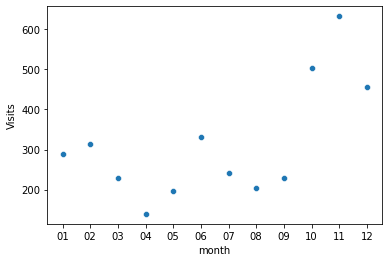

In [113]:
sns.scatterplot(data=month_number, x='month', y='Visits')

In [107]:
Daily_averages = merge_resono_weather.groupby(merge_resono_weather.index.strftime('%A'))[merge_resono_weather.columns].mean()
Daily_averages

,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
Friday,381.444565,4.751559,9.892700,6.315574,0.023339,0.950864,2.709281,0.021286,0.205728,0.001489,0.004965,0.005151
Monday,368.320570,4.896260,9.905711,6.437936,0.029248,1.426500,2.534146,0.013877,0.237129,0.021393,0.010267,0.001420
Saturday,357.755833,4.696870,9.467292,6.576151,0.029873,1.226731,2.323343,0.051222,0.211064,0.010735,0.004809,0.008935
Sunday,336.263201,4.706333,9.948679,6.458868,0.030871,1.267971,2.679947,0.019141,0.236019,0.019201,0.012511,0.001380
Thursday,376.598839,4.747994,9.973542,6.319206,0.027674,1.500729,2.696690,0.025622,0.279801,0.004437,0.001368,0.003890
Tuesday,390.585866,4.668907,10.299104,6.461372,0.029961,1.546226,2.678047,0.004834,0.288235,0.011753,0.007281,0.001813
Wednesday,356.528868,4.928512,10.477672,6.508665,0.028726,1.017464,2.648918,0.031636,0.235461,0.007902,0.009428,0.005387


In [90]:
Hourly_averages = merge_resono_weather.groupby(merge_resono_weather.index.strftime('%H'))[merge_resono_weather.columns].mean()
Hourly_averages = Hourly_averages.reset_index().rename(columns={"index": "Hour"})
Hourly_averages.sort_values(by='Visits', ascending=False)

,Hour,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
15,15,552.982370,5.701700,11.794461,6.541519,0.032472,1.362769,5.348112,0.003130,0.237117,0.012414,0.015335,0.000000
16,16,551.671200,5.424495,11.267413,6.395282,0.040349,1.350612,4.225860,0.007323,0.239879,0.014437,0.015901,0.000000
14,14,549.301229,5.819815,12.113932,6.604175,0.033542,1.475791,5.985319,0.000521,0.270929,0.012078,0.012703,0.000000
13,13,548.339024,5.878786,12.266478,6.588946,0.032811,1.502186,5.834027,0.003643,0.261684,0.010930,0.010097,0.000000
17,17,519.336127,5.102473,10.730197,6.266345,0.025574,1.178594,3.163139,0.009954,0.256391,0.015088,0.011840,0.000000
12,12,513.030583,5.820444,12.239340,6.596983,0.023668,1.176394,5.816349,0.008812,0.232843,0.008086,0.011300,0.000518
18,18,495.282481,4.824549,10.217189,6.211127,0.029374,1.185666,2.037353,0.010478,0.236693,0.013202,0.008906,0.001886
11,11,495.008803,5.624120,11.971878,6.675590,0.019305,1.141466,5.733741,0.010356,0.236537,0.009321,0.009838,0.002071
19,19,485.194153,4.593933,9.779893,6.203112,0.024303,1.099225,0.665759,0.017079,0.228835,0.010687,0.009325,0.004401
10,10,466.485087,5.369615,11.493424,6.674658,0.023157,1.144729,5.559134,0.011392,0.242026,0.008596,0.008285,0.002071


<AxesSubplot:xlabel='Hour', ylabel='Visits'>

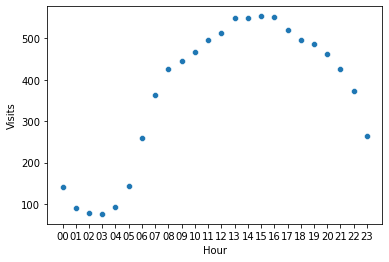

In [91]:
sns.scatterplot(data=Hourly_averages, x='Hour', y='Visits')

<AxesSubplot:>

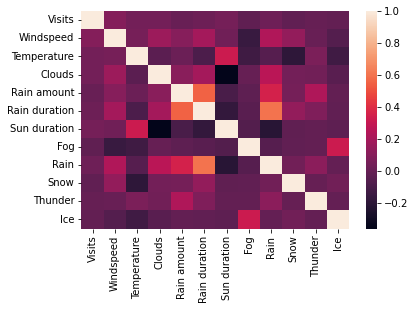

In [128]:
sns.heatmap(merge_resono_weather.corr())

In [138]:
test = merge_resono_weather.between_time('8:00', '22:00')
test.corr()
# merge_resono_weather.corr()

,Visits,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
Visits,1.000000,0.031368,-0.031717,0.048892,0.009460,0.030985,-0.064719,0.016533,0.032149,-0.024354,-0.022029,0.002315
Windspeed,0.031368,1.000000,0.008466,0.157996,0.059588,0.137536,-0.003531,-0.104972,0.197901,0.143694,-0.008066,-0.019785
Temperature,-0.031717,0.008466,1.000000,-0.112010,-0.005323,-0.117721,0.322162,-0.120695,-0.094119,-0.210192,0.080912,-0.081456
Clouds,0.048892,0.157996,-0.112010,1.000000,0.105324,0.193248,-0.445023,0.053380,0.271215,0.049926,0.046081,0.000992
Rain amount,0.009460,0.059588,-0.005323,0.105324,1.000000,0.518929,-0.117493,-0.017341,0.339817,0.024547,0.262515,-0.006335
Rain duration,0.030985,0.137536,-0.117721,0.193248,0.518929,1.000000,-0.220438,-0.026638,0.586473,0.127281,0.099123,-0.011027
Sun duration,-0.064719,-0.003531,0.322162,-0.445023,-0.117493,-0.220438,1.000000,-0.051041,-0.271578,-0.036436,-0.032374,-0.017112
Fog,0.016533,-0.104972,-0.120695,0.053380,-0.017341,-0.026638,-0.051041,1.000000,-0.031558,-0.011674,-0.010947,0.230026
Rain,0.032149,0.197901,-0.094119,0.271215,0.339817,0.586473,-0.271578,-0.031558,1.000000,0.027364,0.133023,0.015468
Snow,-0.024354,0.143694,-0.210192,0.049926,0.024547,0.127281,-0.036436,-0.011674,0.027364,1.000000,-0.007338,0.106996


/var/folders/3y/wg1nvwfd2fgfgy_dxxxkcbsw0000gn/T/ipykernel_19379/4117408593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oosterpark['weekend'] = oosterpark['index'].apply(lambda x: 1 if (x.weekday() == 5) or (x.weekday() == 6) else 0)


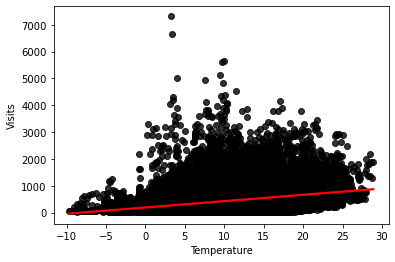

In [176]:
oosterpark = merge_resono_weather[merge_resono_weather.Location == 'Oosterpark'] 
#oosterpark = oosterpark[oosterpark.Visits > 20]
#oosterpark = oosterpark.between_time('08:00', '22:00')
oosterpark.reset_index(inplace=True)
oosterpark['weekend'] = oosterpark['index'].apply(lambda x: 1 if (x.weekday() == 5) or (x.weekday() == 6) else 0)

sns.regplot(data=oosterpark, x="Temperature", y="Visits", scatter_kws={"color": "black"}, line_kws={"color": "red"});

<AxesSubplot:xlabel='Temperature', ylabel='Visits'>

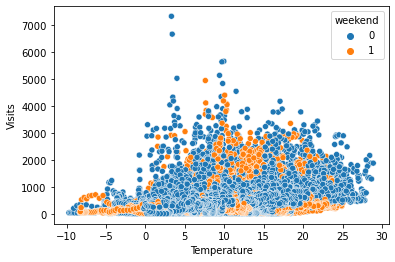

In [177]:
sns.scatterplot(data=oosterpark, x="Temperature", y='Visits', hue='weekend')

<AxesSubplot:xlabel='Windspeed', ylabel='Visits'>

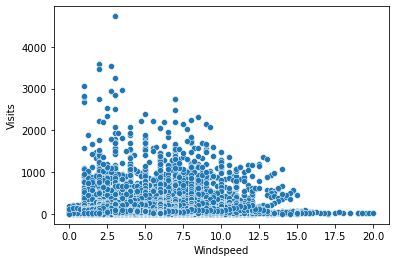

In [189]:
oosterpark = merge_resono_weather[merge_resono_weather.Location == 'Westergasfabriek'] 
oosterpark = oosterpark.between_time('08:00', '22:00')
oosterpark
sns.scatterplot(data=oosterpark, x='Windspeed', y='Visits')

<AxesSubplot:xlabel='Sun duration', ylabel='Visits'>

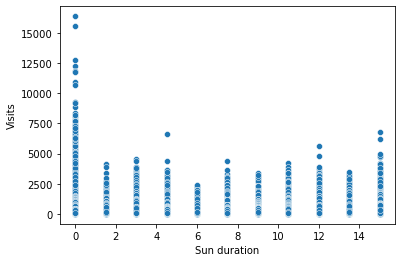

In [190]:
sns.scatterplot(data=merge_resono_weather, x='Sun duration', y='Visits')

In [171]:
'''
Windspeed       = Mean wind speed during the time period (in m/s)
Temperature     = Temperature at 1.50 m at the time of observation
Clouds          = Cloud cover (in octants), at the time of observation (9=sky invisible)
Rain amount     = Quarterly precipitation amount
Rain duration   = Precipitation duration during the quarterly division (in minutes)
Sun duration    = Sunshine duration (in minutes)
Fog             = Fog  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Rain            = Rain  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Snow            = Snow  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Thunder         = Thunder  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Ice             = Ice  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
'''

'\nWindspeed       = Mean wind speed during the time period (in m/s)\nTemperature     = Temperature at 1.50 m at the time of observation\nClouds          = Cloud cover (in octants), at the time of observation (9=sky invisible)\nRain amount     = Quarterly precipitation amount\nRain duration   = Precipitation duration during the quarterly division (in minutes)\nSun duration    = Sunshine duration (in minutes)\nFog             = Fog  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation\nRain            = Rain  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation\nSnow            = Snow  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation\nThunder         = Thunder  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation\nIce             = Ice  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation\n'